## Accessing Data in Google Collab

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Move to where Data is located
%cd 'drive/My Drive/ChBE 6745 Project/Data'

/content/drive/.shortcut-targets-by-id/1C8dheEq3N-3FxfXYpvTW6P2eth8rAiLm/ChBE 6745 Project/Data


# **1. Data Preparation**


### 1.1 Read Original Data

In [1]:
# Read in the data
import numpy as np
import pandas as pd
import pylab as plt
df = pd.read_csv("data/MCC_raw.csv")
data = df.drop([0]).astype(float)
data.head()

,Adhesive-1-1,Unnamed: 1,Unnamed: 2,Adhesive-2-1,Unnamed: 4,Unnamed: 5,Adhesive-3-1,Unnamed: 7,Unnamed: 8,Adhesive-4-1,...,Unnamed: 113,Fiber-17,Unnamed: 115,Unnamed: 116,Fiber-18,Unnamed: 118,Unnamed: 119,Fiber-19,Unnamed: 121,Unnamed: 122
1,73.744,4.570,0.084,74.630,5.286,0.067,74.621,4.898,0.061,74.539,...,-0.034,73.866,4.474,0.016,74.566,5.061,0.040,73.599,5.051,-0.007
2,73.711,6.830,0.024,74.653,7.127,0.055,74.683,6.988,0.139,74.552,...,-0.066,73.889,6.175,0.020,74.599,6.919,0.037,73.637,6.740,0.037
3,73.749,8.960,0.005,74.659,8.873,0.029,74.715,8.493,0.094,74.519,...,-0.079,73.901,7.630,0.035,74.622,8.775,0.056,73.658,7.944,0.059
4,73.741,9.812,0.030,74.688,10.275,0.035,74.724,9.658,0.041,74.498,...,-0.059,73.928,8.643,0.040,74.609,10.098,0.010,73.653,9.038,0.016
5,73.780,10.874,0.031,74.745,11.123,0.086,74.745,10.535,0.030,74.478,...,-0.029,73.933,9.300,0.032,74.644,10.662,0.023,73.733,9.599,0.076


In [2]:
# Read in Flame Retardant Test Results
df = pd.read_csv("data/FR_results.csv")
FR_labels = df.iloc[:,1]
df.head()

,Material,Result
0,Adhesive-1,2
1,Adhesive-2,2
2,Adhesive-3,1
3,Adhesive-4,0
4,Adhesive-5,0


## **1.2 Extract physical features**

### **Baseline correction**

To calculate most accurate features, the baseline corrected curve should be flat (no slope for the area before and after main peaks) and smooth (with no small peaks before 300C). Therefore, the baseline correction function can be divided into three steps, including (1) curve flattening


(1) curve flattening: 

the original dataset might result in a slope (can be either descending or ascending) before  and after the main peaks. To obtain accurate results, the slope area must be flattened. A library called Rampy, which was developed by Charles, et. al. from the Australian National University, was applied to flatten the tilt area.

In [3]:
# run if rampy is not installed
%pip install rampy
# imports
import rampy as rp
from scipy.signal import savgol_filter

Note: you may need to restart the kernel to use updated packages.


In [4]:
def baseflatten(x,y):
    bir = np.array([[0,800]])
    y_corrected, background = rp.baseline(x,y,bir,"arPLS",lam=10**10) #flatten the curve
    y_corrected_filtered=savgol_filter(y_corrected.flatten(),15,3) #smooth the gradient curve
    return y_corrected_filtered

### **Total Heat Release Rate (THR)**

>Total Heat Release Rate (THR) is the area under the curve

In [5]:
# imports
import scipy
from scipy import integrate

# Calculates the area under the curve
#
# params: x, array of temperature values; y, array of HRR values
# returns: THR, the value for total heat release rate

def calculate_THR(Temp,HRR):
    return np.trapz(HRR,Temp)

### **Burning Temperature**

> $T_{burning}$ = The temperature when 95% of the heat is released for the material

In [6]:
# Finds the temperature corresponding to the highest peak
#
# params: x, array of temperature values; y, array of HRR values
# returns: Tb, the burning temperature
def calculate_Tb(Temp,HRR):
    THR = calculate_THR(Temp, HRR)
    for i in range(len(Temp)):
      #print(np.trapz(HRR[:i]))
      #if np.trapz(HRR[:i],Temp) >= 0.50*THR:
        if np.trapz(HRR[:i],Temp[:i]) >= 0.95*THR:
            break
    # return Temp[np.argmax(HRR)]
    return Temp[i]


### **Ignition Temperature**

> $T_{ignition}$ = The temperature at peak HRR

In [7]:
# Finds the temperature corresponding to start of the highest peak
#
# params: x, array of temperature values; y, array of HRR values
# returns: Tign, the ignition temperature
def calculate_Tign(Temp,HRR):
    return Temp[np.argmax(HRR)]

### **Heat Release Capacity (HRC)**

> HRC = $\frac{Peak Heat Released}{Heat of Pyrolysis}$ = $\frac{HRR_Peak}{HR_{average}}$

In [8]:
# Calculates HRC using THR and heat of pyrolysis (Q/HR_average)
#
# params: THR, the total heat release; Tign, ignition temperature; Tinf, final temperature?
# returns: HRC, the heat release capacity
def calculate_HRC(HRR,HR):
    HR_average = np.average(HR)
    HRC = HRR.max()/HR_average
    return HRC

### **Fire Growth Capacity (FGC)**

> FGC = $(\frac{THR}{T_{burning} - T_{ignition}})(\frac{T_{burning} - T_0}{T_{ignition} - T_0})$  
 ($T_0$ = 25$^{\circ}$C)

In [9]:
# Calculates the FGC using THR, ignition temperature, and burning temperature
#
# params: THR, the total heat release; Tign, ignition temperature; Tb, burning temperature
# returns: FGC, the fire growth capacity
def calculate_FGC(THR, Tb, Tign):
    FGC = (THR/(Tb - Tign))/((Tb - 25)/(Tign - 25))
    return FGC

### ***Generation of physical feature matrix***

In [10]:
# setup lists to store desired features
THRs = []
Tbs = []
Tigns = []
HRCs = []
FGCs = []

# Iterate and generate arrays for desired features
for i in range(0, data.shape[1], 3):
    # extract values for x and y and HR
    select = data.iloc[:,i:i+3]
    select = select.dropna()
    x = select.iloc[:,0].values
    y = select.iloc[:,1].values
    HR = select.iloc[:,2].values

    # perform data manipulation to get desired features
    x_b=x
    y_b= baseflatten(x,y)
    #x_b, y_b=x,y
    y_b = y_b.reshape(-1)
    THR = calculate_THR(x_b,y_b)
    Tb = calculate_Tb(x_b,y_b)
    Tign = calculate_Tign(x_b,y_b)
    HRC = calculate_HRC(y_b,HR)
    FGC = calculate_FGC(THR, Tb, Tign)
    THRs.append(THR)
    Tbs.append(Tb)
    Tigns.append(Tign)
    HRCs.append(HRC)
    FGCs.append(FGC)

# setup dataframe for feature matrix
feature_matrix = pd.DataFrame()
feature_matrix['Total Heat Release'] = THRs
feature_matrix['Burning Temperature'] = Tbs
feature_matrix['Ignition Temperature'] = Tigns
feature_matrix['Heat Release Capacity'] = HRCs
feature_matrix['Fire Growth Capacity'] = FGCs

# Add column for FR test result labels
feature_matrix['FR_labels'] = FR_labels

feature_matrix

/Users/jonathanhsu/opt/anaconda3/lib/python3.8/site-packages/rampy/baseline.py:239: RuntimeWarning: overflow encountered in exp
  wt = 1.0/(1 + np.exp( 2* (d-(2*s-m))/s ) )
/Users/jonathanhsu/opt/anaconda3/lib/python3.8/site-packages/rampy/baseline.py:239: RuntimeWarning: overflow encountered in exp
  wt = 1.0/(1 + np.exp( 2* (d-(2*s-m))/s ) )
/Users/jonathanhsu/opt/anaconda3/lib/python3.8/site-packages/rampy/baseline.py:239: RuntimeWarning: overflow encountered in exp
  wt = 1.0/(1 + np.exp( 2* (d-(2*s-m))/s ) )
/Users/jonathanhsu/opt/anaconda3/lib/python3.8/site-packages/rampy/baseline.py:239: RuntimeWarning: overflow encountered in exp
  wt = 1.0/(1 + np.exp( 2* (d-(2*s-m))/s ) )
/Users/jonathanhsu/opt/anaconda3/lib/python3.8/site-packages/rampy/baseline.py:239: RuntimeWarning: overflow encountered in exp
  wt = 1.0/(1 + np.exp( 2* (d-(2*s-m))/s ) )
/Users/jonathanhsu/opt/anaconda3/lib/python3.8/site-packages/rampy/baseline.py:239: RuntimeWarning: overflow encountered in exp
  wt = 

,Total Heat Release,Burning Temperature,Ignition Temperature,Heat Release Capacity,Fire Growth Capacity,FR_labels
0,24722.818517,482.246,350.805,226.086018,134.021649,2
1,14879.480392,537.858,438.643,167.301374,120.959219,2
2,16584.116501,515.457,366.537,115.388857,77.548988,1
3,20246.452607,482.774,396.996,234.511889,191.805110,0
4,26622.142067,472.215,388.929,403.934907,260.118532,0
5,12581.675639,488.529,292.177,287.523491,36.933912,1
6,27364.231613,468.963,377.870,444.419598,238.762552,0
7,14539.335519,469.506,384.928,187.059855,139.195486,1
8,15665.463662,437.267,334.539,424.940076,114.496239,1
9,13535.355054,461.318,343.769,223.623054,84.124726,1


## **1.3 Extract Principal component features**

###PCA (Principal Component Analysis)

Principal Component Analysis (PCA) will be performed on the original MCC dataset, which includes raw data and curve-flattened data. 10 most important PCs will be extracted from each dataset and return a (41*10) feature matrix. This matrix, itself, will be used as the input for the prediction model. In addition, the PCA extracted matrix will be combined with the original feature matrix for prediction.

In [11]:
# Read in the raw data
df = pd.read_csv("data/MCC_raw.csv")
data_raw = df.drop([0]).astype(float)
data_raw[data_raw.columns[::3]].head(5)

,Adhesive-1-1,Adhesive-2-1,Adhesive-3-1,Adhesive-4-1,Adhesive-5-1,Adhesive-6-1,Adhesive-7-1,Adhesive-8-1,Adhesive-9-1,Adhesive-10-1,...,Fiber-FR-10,Fiber-FR-11,Fiber-FR-12,Fiber-FR-13,Fiber-FR-14,Fiber-FR-15,Fiber-FR-16,Fiber-17,Fiber-18,Fiber-19
1,73.744,74.630,74.621,74.539,74.815,75.161,75.574,74.589,75.411,75.404,...,74.736,75.393,74.683,73.755,74.602,74.629,75.068,73.866,74.566,73.599
2,73.711,74.653,74.683,74.552,74.815,75.181,75.580,74.628,75.390,75.352,...,74.719,75.416,74.691,73.679,74.588,74.670,75.021,73.889,74.599,73.637
3,73.749,74.659,74.715,74.519,74.893,75.207,75.582,74.650,75.376,75.345,...,74.678,75.360,74.725,73.665,74.604,74.699,74.989,73.901,74.622,73.658
4,73.741,74.688,74.724,74.498,74.904,75.236,75.617,74.704,75.397,75.335,...,74.652,75.418,74.756,73.647,74.628,74.735,74.962,73.928,74.609,73.653
5,73.780,74.745,74.745,74.478,74.951,75.237,75.603,74.720,75.365,75.320,...,74.669,75.412,74.765,73.607,74.704,74.778,74.959,73.933,74.644,73.733


In [12]:
# Drop all non-numerical (NaN) values
def is_positive_numeric(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    elif pd.isnull(x):
        return False
    else:
        return True
    
numeric_map = data_raw.applymap(is_positive_numeric)
data=data_raw[numeric_map.all(axis=1).values]
data.tail(5)

,Adhesive-1-1,Unnamed: 1,Unnamed: 2,Adhesive-2-1,Unnamed: 4,Unnamed: 5,Adhesive-3-1,Unnamed: 7,Unnamed: 8,Adhesive-4-1,...,Unnamed: 113,Fiber-17,Unnamed: 115,Unnamed: 116,Fiber-18,Unnamed: 118,Unnamed: 119,Fiber-19,Unnamed: 121,Unnamed: 122
1395,737.295,-0.002,1.016,739.624,-5.602,1.014,739.985,-6.388,1.034,735.241,...,0.998,737.426,-0.924,1.025,738.191,1.522,1.009,737.991,3.252,1.013
1396,737.805,0.102,1.022,740.144,-5.294,1.021,740.486,-6.147,1.003,735.757,...,1.017,737.927,-0.815,1.019,738.698,1.733,1.001,738.499,3.296,1.025
1397,738.282,0.155,0.987,740.684,-5.458,1.061,741.009,-6.113,1.025,736.241,...,1.040,738.441,-0.762,1.015,739.192,1.684,1.001,739.003,3.080,1.014
1398,738.803,0.020,0.996,741.150,-5.387,1.007,741.526,-6.189,1.040,736.738,...,1.004,738.957,-0.871,1.030,739.718,1.605,1.019,739.498,3.180,0.998
1399,739.309,0.060,1.028,741.652,-5.352,0.969,742.025,-6.322,1.015,737.225,...,1.004,739.427,-0.804,0.985,740.200,1.433,1.007,740.014,3.073,1.010


In the following cell, two 2-D arrays storing the x values (temperature) and y values (HRR) are created. 

1) xy_raw: x & y values for raw data

2) xy_flattened: x & y values for curve flattened data

In [13]:
import warnings
warnings.filterwarnings("ignore") 
xy_raw=[]
xy_flattened=[]
xy_corrected=[]
for i in range(0, data.shape[1], 3):
    # extract values for x and y and HR
    select = data.iloc[:,i:i+3]
    x = select.iloc[:,0].values
    xy_raw.append(x)
    xy_flattened.append(x)
    
    y = select.iloc[:,1].values
    xy_raw.append(y)
    
    y_b= baseflatten(x,y) #flatten the curve
    xy_flattened.append(y_b.flatten())

    # Uncomment the codes to check the baseline corrected curves

    #fig, ax=plt.subplots()
    #ax.plot(x,y,label='original data')
    #ax.plot(x,y_b,label='flattened data')
    #ax.legend()

xy_raw=np.array(xy_raw)
xy_flattened=np.array(xy_flattened)

y values (HRR values) will be used for PCA, the following cells will extract two matrices with 41 rows (observations) and 1399 columns (y values as features). 

In [14]:
features_raw=xy_raw[1::2,:]
print(features_raw.shape)
features_flattened=xy_flattened[1::2,:]
print(features_flattened.shape)

(41, 1399)
(41, 1399)


Because the x values deviate slightly among each observation, it might lead to error if we use original y values directly. Therefore, for each observation, a linear interpolation will be performed and all y values will be re-calculated based on the same x values. Aligned feature matrices and heatmap for correlation matrices are printed below 

In [15]:
from scipy import interpolate
# define new aligned x values
x_aligned=np.linspace(max(xy_raw[::2,1]),min(xy_raw[::2,-1]),num=1400)

# function interpolating each observations, and return a new feature matrix with aligned x values
def align_data(xy_inp):
    features_inp_aligned=[]
    for i in range(0,41):
        x = xy_inp[2*i,:]
        y=xy_inp[2*i+1,:]
        
        # interpolate the curve
        interp = interpolate.interp1d(x, y)
        y_aligned=interp(x_aligned)
        features_inp_aligned.append(y_aligned)

        # Uncomment the codes to check the interpolation results
        
        #fig, ax=plt.subplots()
        #ax.plot(x,y,label='original data')
        #ax.plot(x_aligned,y_aligned,label='interpolated data')
        #ax.legend()
    features_inp_aligned=np.array(features_inp_aligned)
    return features_inp_aligned

In [16]:
# Calculate feature matrices with aligned data
features_raw_aligned=align_data(xy_raw)
features_flattened_aligned=align_data(xy_flattened)
print(features_raw_aligned.shape)
print(features_flattened_aligned.shape)

(41, 1400)
(41, 1400)


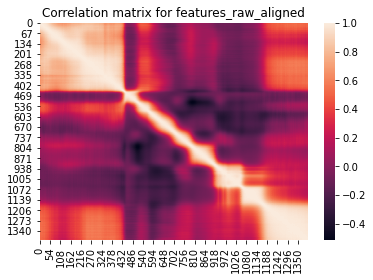

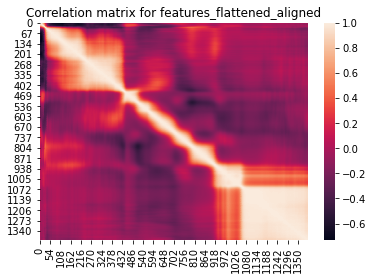

In [17]:
import seaborn as sns
corr_raw_aligned=np.corrcoef(features_raw_aligned.T)
hm1=sns.heatmap(corr_raw_aligned).set_title('Correlation matrix for features_raw_aligned')

plt.figure()
corr_flattened_aligned=np.corrcoef(features_flattened_aligned.T)
hm2=sns.heatmap(corr_flattened_aligned).set_title('Correlation matrix for features_flattened_aligned')

Find the first 10 PCs based on aligned features

In [18]:
from sklearn.decomposition import PCA
k=10
pca_raw=PCA(n_components=k)
pca_flattened=PCA(n_components=k)

raw_pc=pca_raw.fit_transform(features_raw_aligned)
print(raw_pc[0,:])

flattened_pc=pca_flattened.fit_transform(features_flattened_aligned)
print(flattened_pc[0,:])

[-686.42103209  311.84630269  710.71679886 -241.66235881  837.55141237
  -73.54494024   35.39005441  -50.01410213  132.44691814 -177.28925653]
[-675.35966478  297.70609534  709.67296853 -210.10418253  880.68519073
   14.37603541   74.34793143   49.63832081  170.41499748 -148.95424958]


Text(0.5, 1.0, 'Explained Variance for flattened data')

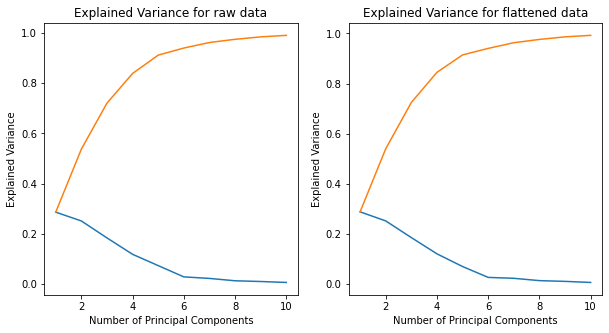

In [19]:
raw_mean=raw_pc.mean(axis=0)
flattened_mean=flattened_pc.mean(axis=0)

fig,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1,len(raw_mean)+1),pca_raw.explained_variance_ratio_)
axes[0].plot(range(1,len(raw_mean)+1),np.cumsum(pca_raw.explained_variance_ratio_))
axes[0].set_xlabel('Number of Principal Components')
axes[0].set_ylabel('Explained Variance')
axes[0].set_title('Explained Variance for raw data')

axes[1].plot(range(1,len(flattened_mean)+1),pca_flattened.explained_variance_ratio_)
axes[1].plot(range(1,len(flattened_mean)+1),np.cumsum(pca_flattened.explained_variance_ratio_))
axes[1].set_xlabel('Number of Principal Components')
axes[1].set_ylabel('Explained Variance')
axes[1].set_title('Explained Variance for flattened data')

Text(0.5, 1.0, 'Reconstructed PCs for flattened data')

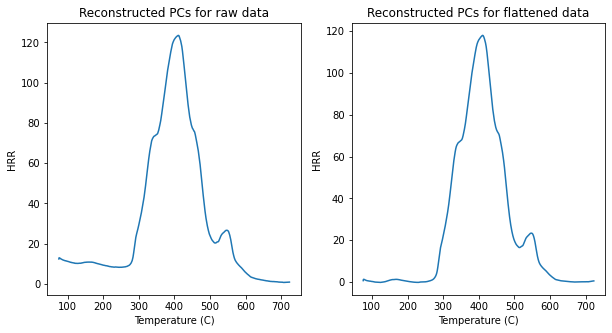

In [20]:
raw_reconstructed=pca_raw.inverse_transform(raw_mean)
flattened_reconstructed=pca_flattened.inverse_transform(flattened_mean)

fig,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(x_aligned,raw_reconstructed)
axes[0].set_xlabel('Temperature (C)')
axes[0].set_ylabel('HRR')
axes[0].set_title('Reconstructed PCs for raw data')

axes[1].plot(x_aligned,flattened_reconstructed)
axes[1].set_xlabel('Temperature (C)')
axes[1].set_ylabel('HRR')
axes[1].set_title('Reconstructed PCs for flattened data')

# **2. Baseline Model**

### 2.1 Import Modified Feature Matrix

Only physical features are accounted for the baseline model.

The feature matrixcontains features extracted from raw data based on physical meanings, as well as the labels indicating whether the material passes FR tests or not. A total of 41 observations and 5 features were included. Specifically, the output consists of 3 labels, where 0=fail, 1=pass, 2=hard to determine.

In [21]:
# Read in the data
import numpy as np
import pandas as pd
import pylab as plt
data=feature_matrix
data.head()

,Total Heat Release,Burning Temperature,Ignition Temperature,Heat Release Capacity,Fire Growth Capacity,FR_labels
0,24722.818517,482.246,350.805,226.086018,134.021649,2
1,14879.480392,537.858,438.643,167.301374,120.959219,2
2,16584.116501,515.457,366.537,115.388857,77.548988,1
3,20246.452607,482.774,396.996,234.511889,191.805110,0
4,26622.142067,472.215,388.929,403.934907,260.118532,0


### 2.2 Scale Data

Based on simple observation on the raw features, it is not suprised to see there are magnitude difference among all features. To eliminate the weight bias caused by descrepancy with units, standard scaling is applied and all analysis will be performed on top of the scaled dataset.

In [22]:
# import standard scaler
from sklearn.preprocessing import StandardScaler

# scale the data (excluding labels)
scaler = StandardScaler()
scaled = scaler.fit_transform(data.drop(columns='FR_labels'))
scaled = pd.DataFrame(scaled)
scaled['FR_labels'] = data.loc[:,'FR_labels']    # add FR_labels to new dataframe
scaled.columns = data.columns    # add column headers back to new dataframe
scaled.head()

,Total Heat Release,Burning Temperature,Ignition Temperature,Heat Release Capacity,Fire Growth Capacity,FR_labels
0,1.808411,-0.424203,-0.990329,-0.240135,-0.202424,2
1,-0.335103,0.879587,0.744864,-0.797272,-0.258909,2
2,0.036103,0.354409,-0.679551,-1.289277,-0.446622,1
3,0.833624,-0.411824,-0.077850,-0.160279,0.047441,0
4,2.222013,-0.659374,-0.237209,1.445442,0.342840,0


## 2.3 SVC Baseline Model

According to the pipeline diagram in our description file, a 90% train-test split will be performed to the scaled dataset. Support Vector Classifier (SVC) is selected as our baseline model. GridSearchCV is used for determining the optimal hyperparameters ($C$ and $\gamma$) with a 3-fold cross-validation. At the end, the accuracy, precision and recall scores are printed as benchmark metrics with other potential models.

Our Support Vector Classifier (SVC) baseline model will not consider previously discussed issues of multicollinearity and outliers with the data but will establish the baseline performance for a classification model. Because dropping the outlier at index=2 made a significant difference, we will be dropping that data point for the baseline but further exploring its significance in the future.

In [23]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# final outlier
origin_feature=scaled

# perform a train-test split. 90% of original data will be used for training
X_svc = origin_feature.drop(columns='FR_labels').values
y_svc = origin_feature['FR_labels'].values
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_svc, test_size = 0.10)

# define support vector model with rbf kernel
svc = SVC(kernel = 'rbf')

# build up parameter grid and perform GridSearchCV to find the best estimator
alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
Cs = 1 / alphas
sigmas = np.array([1e-3, 1e-2, 1e-1, 1, 10, 100])
gammas = 1. / 2 / sigmas**2

param_grid_svc = {'C': Cs,'gamma': gammas}

svc_search = GridSearchCV(svc, param_grid_svc, cv = 3)
svc_search.fit(X_train_svc,y_train_svc)

# resulting predictions
predict_svc = svc_search.best_estimator_.predict(X_test_svc)
full_predict_svc = svc_search.best_estimator_.predict(X_svc)

# note: we have 3 labels, so we use average='macro' to find the average metric for each
#       label summed. This augments penalized performance caused by class imbalance.
# print out the accuracy, precison and recall score for the prediction on validation set
print('Accuracy for validation set: {}'.format(accuracy_score(y_test_svc, predict_svc)))
print('Precision for validation set: {}'.format(precision_score(y_test_svc, predict_svc, average='macro')))
print('Recall for validation set: {}\n'.format(recall_score(y_test_svc, predict_svc, average='macro')))

# print out the accuracy, precison and recall score for the prediction on full dataset
print('Accuracy for full dataset: {}'.format(accuracy_score(y_svc, full_predict_svc)))
print('Precision for full dataset: {}'.format(precision_score(y_svc, full_predict_svc, average='macro')))
print('Recall for full dataset: {}'.format(recall_score(y_svc, full_predict_svc, average='macro')))

Accuracy for validation set: 0.6
Precision for validation set: 0.5
Recall for validation set: 0.38888888888888884

Accuracy for full dataset: 0.926829268292683
Precision for full dataset: 0.8849206349206349
Recall for full dataset: 0.9462962962962962


**Baseline Model Discussion:**  
After running the above cell a few times, we notice that the score changes drastically based on the random set of X_train, y_train chosen. This is caused by our small data set and should be addressed in future models by generating or obtaining additional data. Additionally, due to the same problem, sometimes the model is unable to predict the borderline class (label 2) shown in the warning above, which is composed of materials that do not have a fixed flame retardant test result (sometimes pass and sometimes fail).

With regards to scores of the validation set and the full dataset, it seems that the data is not overfitting much and seems to generalize well when applied to the larger data set.

# **3. Improved Models**

In [24]:
# Read in the data
import numpy as np
import pandas as pd
import pylab as plt
#data = pd.read_csv("feature_matrix.csv")
data = feature_matrix
y_label=data['FR_labels'].values
data.head()

,Total Heat Release,Burning Temperature,Ignition Temperature,Heat Release Capacity,Fire Growth Capacity,FR_labels
0,24722.818517,482.246,350.805,226.086018,134.021649,2
1,14879.480392,537.858,438.643,167.301374,120.959219,2
2,16584.116501,515.457,366.537,115.388857,77.548988,1
3,20246.452607,482.774,396.996,234.511889,191.805110,0
4,26622.142067,472.215,388.929,403.934907,260.118532,0


## 3.1 Generative Model

In [25]:
#feature_matrix = pd.read_csv("feature_matrix.csv")
feature_matrix['PC1'] = flattened_pc[:,0]
feature_matrix['PC2'] = flattened_pc[:,1]
feature_matrix['PC3'] = flattened_pc[:,2]
feature_matrix.head(10)

,Total Heat Release,Burning Temperature,Ignition Temperature,Heat Release Capacity,Fire Growth Capacity,FR_labels,PC1,PC2,PC3
0,24722.818517,482.246,350.805,226.086018,134.021649,2,-675.359665,297.706095,709.672969
1,14879.480392,537.858,438.643,167.301374,120.959219,2,909.690780,342.229118,38.531565
2,16584.116501,515.457,366.537,115.388857,77.548988,1,63.184653,-388.364698,435.757341
3,20246.452607,482.774,396.996,234.511889,191.805110,0,785.953021,1344.401641,280.523430
4,26622.142067,472.215,388.929,403.934907,260.118532,0,-1375.196724,1562.118235,335.994676
5,12581.675639,488.529,292.177,287.523491,36.933912,1,312.466980,-994.661003,-171.510428
6,27364.231613,468.963,377.870,444.419598,238.762552,0,-1823.270483,1123.422331,811.067096
7,14539.335519,469.506,384.928,187.059855,139.195486,1,-673.781299,-70.424785,63.789112
8,15665.463662,437.267,334.539,424.940076,114.496239,1,-534.780150,-1735.166289,67.101104
9,13535.355054,461.318,343.769,223.623054,84.124726,1,-613.962714,-1013.198967,282.618511


In [26]:
data = feature_matrix
# import standard scaler
from sklearn.preprocessing import StandardScaler

# scale the data (excluding labels)
scaler = StandardScaler()
scaled = scaler.fit_transform(data.drop(columns='FR_labels'))
scaled = pd.DataFrame(scaled)
scaled.columns = data.drop(columns='FR_labels').columns
scaled['FR_labels'] = data.loc[:,'FR_labels']    # add FR_labels to new dataframe
scaled.head()
origin_feature_matrix=scaled
origin_feature_matrix.shape

(41, 9)

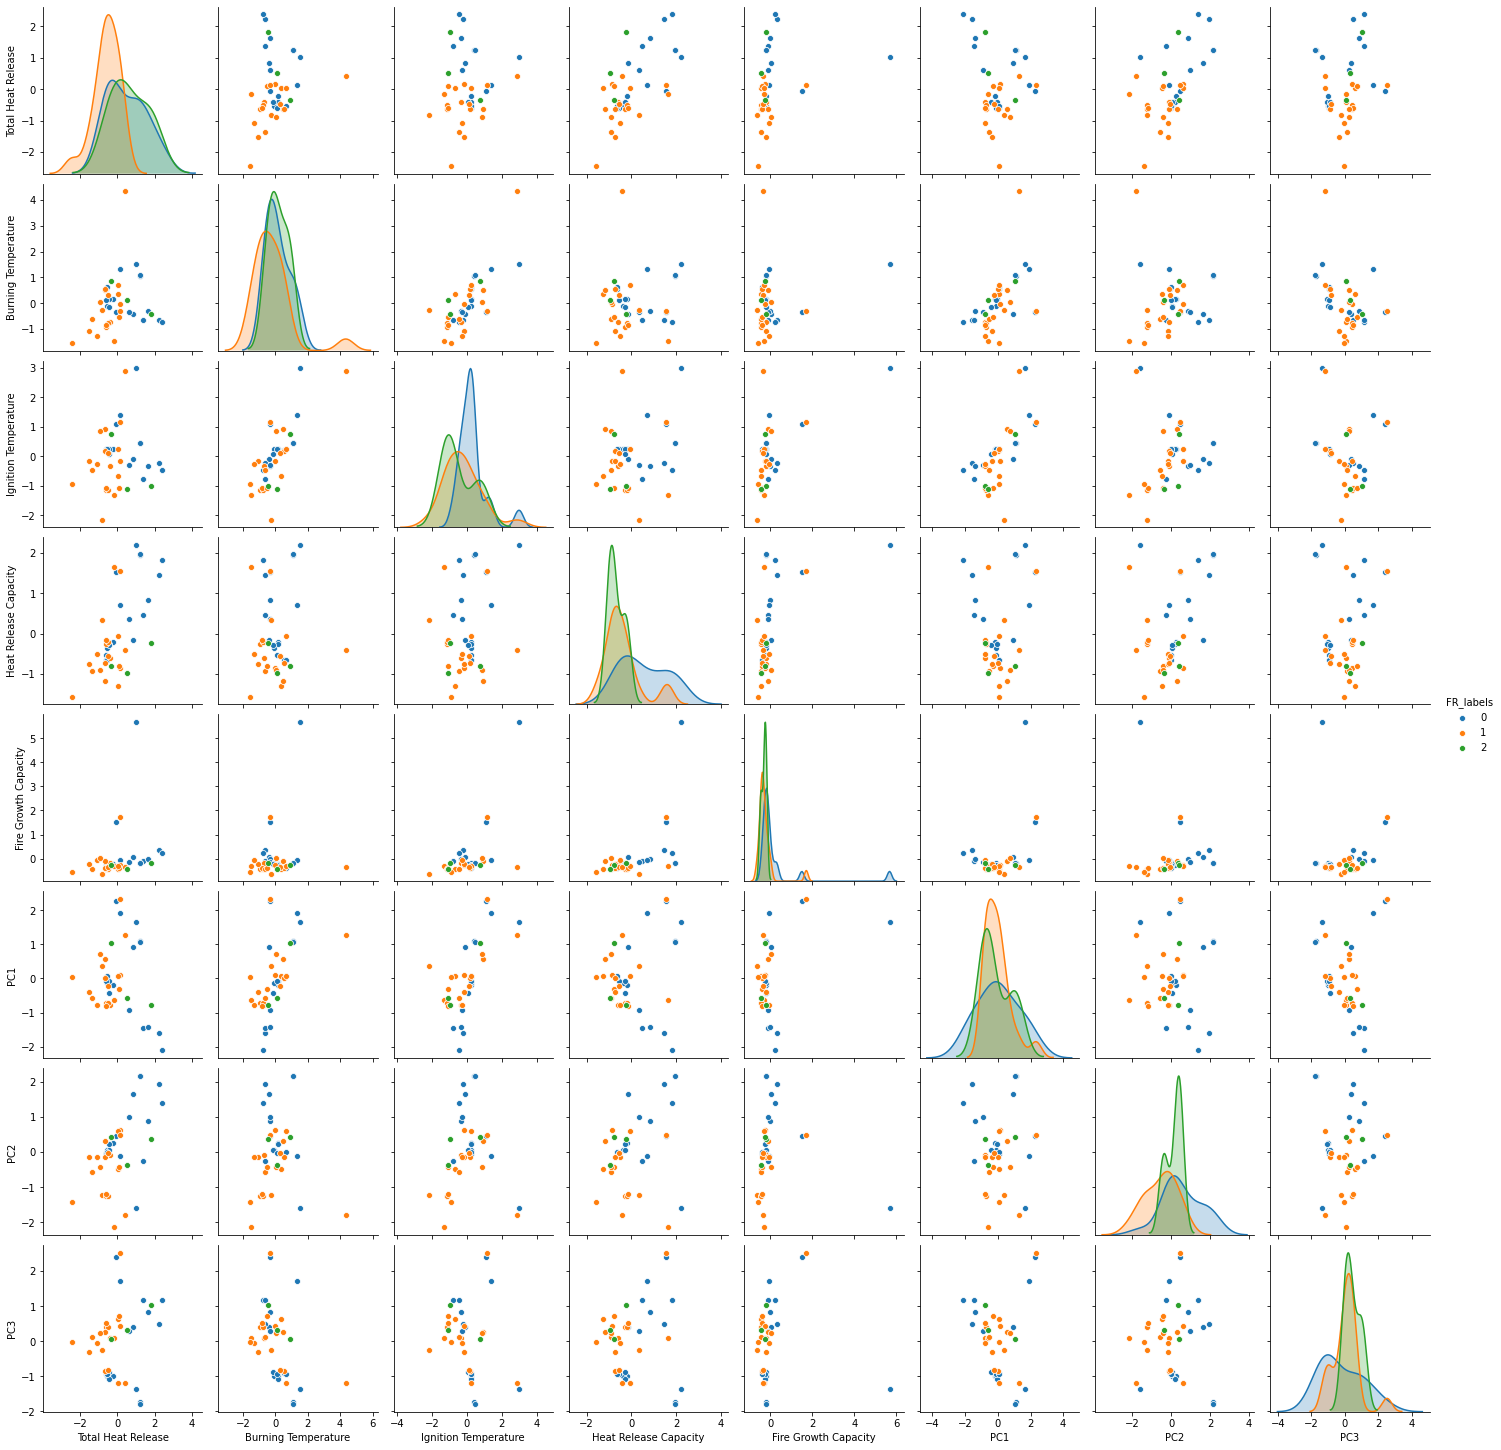

In [27]:
# plot
import seaborn as sns
sns.pairplot(scaled,hue='FR_labels')

In [28]:
from sklearn.model_selection import train_test_split
X = scaled.drop(columns='FR_labels').values
y = scaled['FR_labels'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=3)

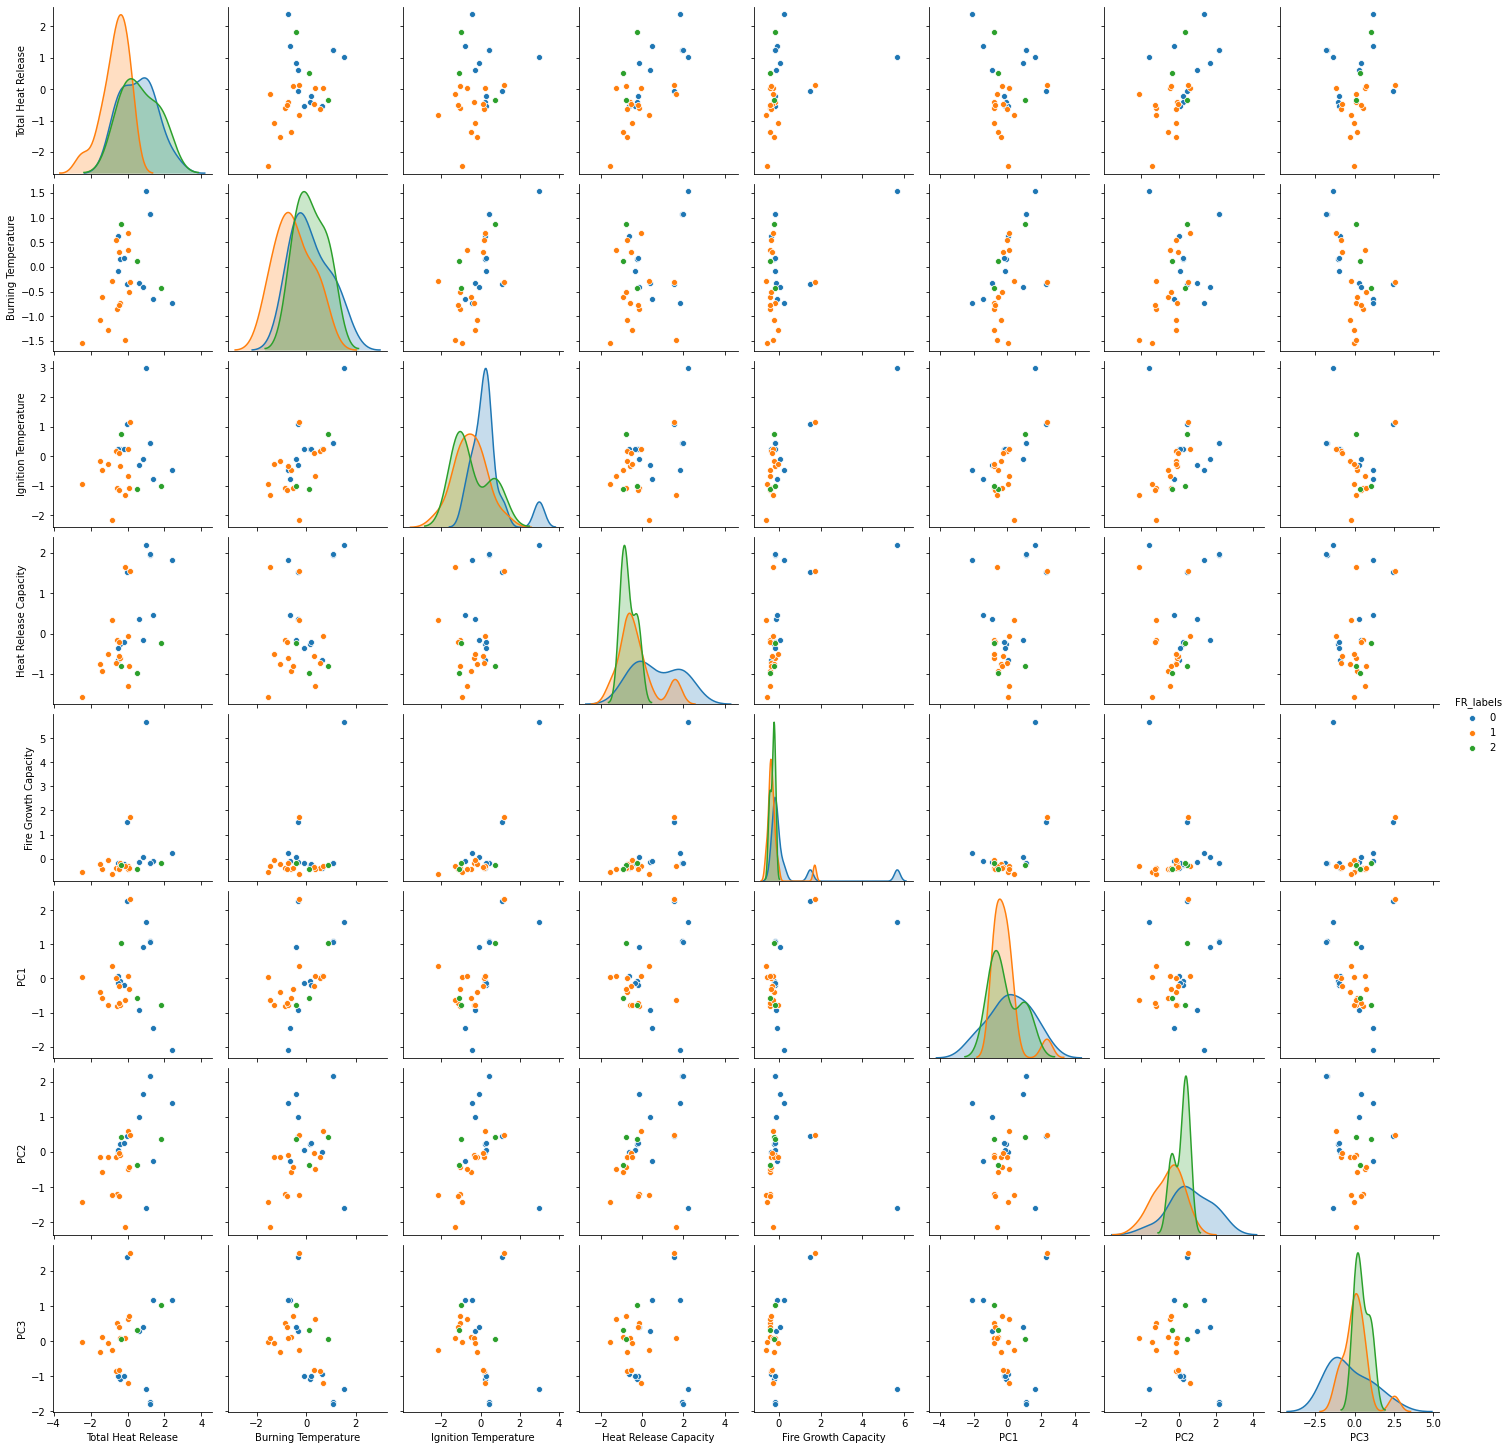

In [29]:
train = pd.DataFrame(X_train)
train.columns = data.drop(columns='FR_labels').columns
train['FR_labels'] = y_train
sns.pairplot(train,hue='FR_labels')

### Gaussian Mixture Method

[8]


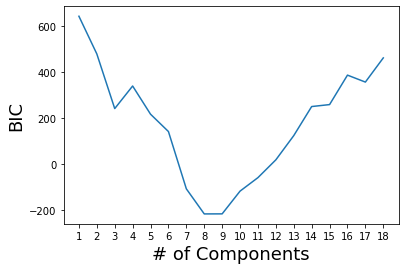

In [30]:
#y = scaled['FR_labels']
y = y_train
from sklearn.mixture import GaussianMixture

#X = scaled.drop(columns='FR_labels')[y == 0].values
X = X_train
n_components = np.arange(1, 19)

BICs = []
models = []
for n in n_components:
    gmm_n =  GaussianMixture(n, covariance_type = 'full',random_state=0).fit(X)
    bic = gmm_n.bic(X)
    BICs.append(bic)
    models.append(gmm_n)
        
fig, ax = plt.subplots()
ax.plot(n_components, BICs)
ax.set_xlabel('# of Components', size = 18);
ax.set_ylabel('BIC', size = 18)
ax.set_xticks(n_components);
best_n=[]
best_n.append(n_components[BICs == min(BICs)][0])
print(best_n)

[8, 8]


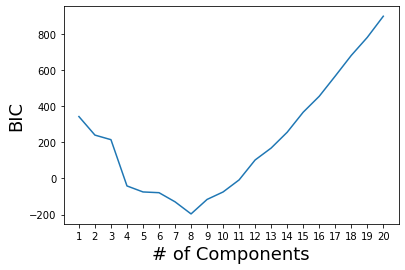

In [31]:
y = scaled['FR_labels']
from sklearn.mixture import GaussianMixture

X = scaled.drop(columns='FR_labels')[y == 1].values
n_components = np.arange(1, 21)

BICs = []
models = []
for n in n_components:
    gmm_n =  GaussianMixture(n, covariance_type = 'full',random_state=0).fit(X)
    bic = gmm_n.bic(X)
    BICs.append(bic)
    models.append(gmm_n)
    
        
fig, ax = plt.subplots()
ax.plot(n_components, BICs)
ax.set_xlabel('# of Components', size = 18);
ax.set_ylabel('BIC', size = 18)
ax.set_xticks(n_components);
best_n.append(n_components[BICs == min(BICs)][0])
print(best_n)

In [32]:
vals = []
for i in range(0,2):
  X = scaled.drop(columns='FR_labels')[y == i].values
  gmm = GaussianMixture(n_components = best_n[i], covariance_type = 'full',random_state=0)
  gmm.fit(X)
  new = gmm.sample(100)
  vals.append(new[0])

In [33]:
new0 = pd.DataFrame(vals[0])
new0['FR_labels'] = np.zeros(100).astype(int)
new0.columns = scaled.columns
new1 = pd.DataFrame(vals[1])
new1['FR_labels'] = np.ones(100).astype(int)
new1.columns = scaled.columns
#final = scaled.append(new0)
#final = final.append(new1)
final = train.append(new0)
final = final.append(new1)
final.shape

(230, 9)

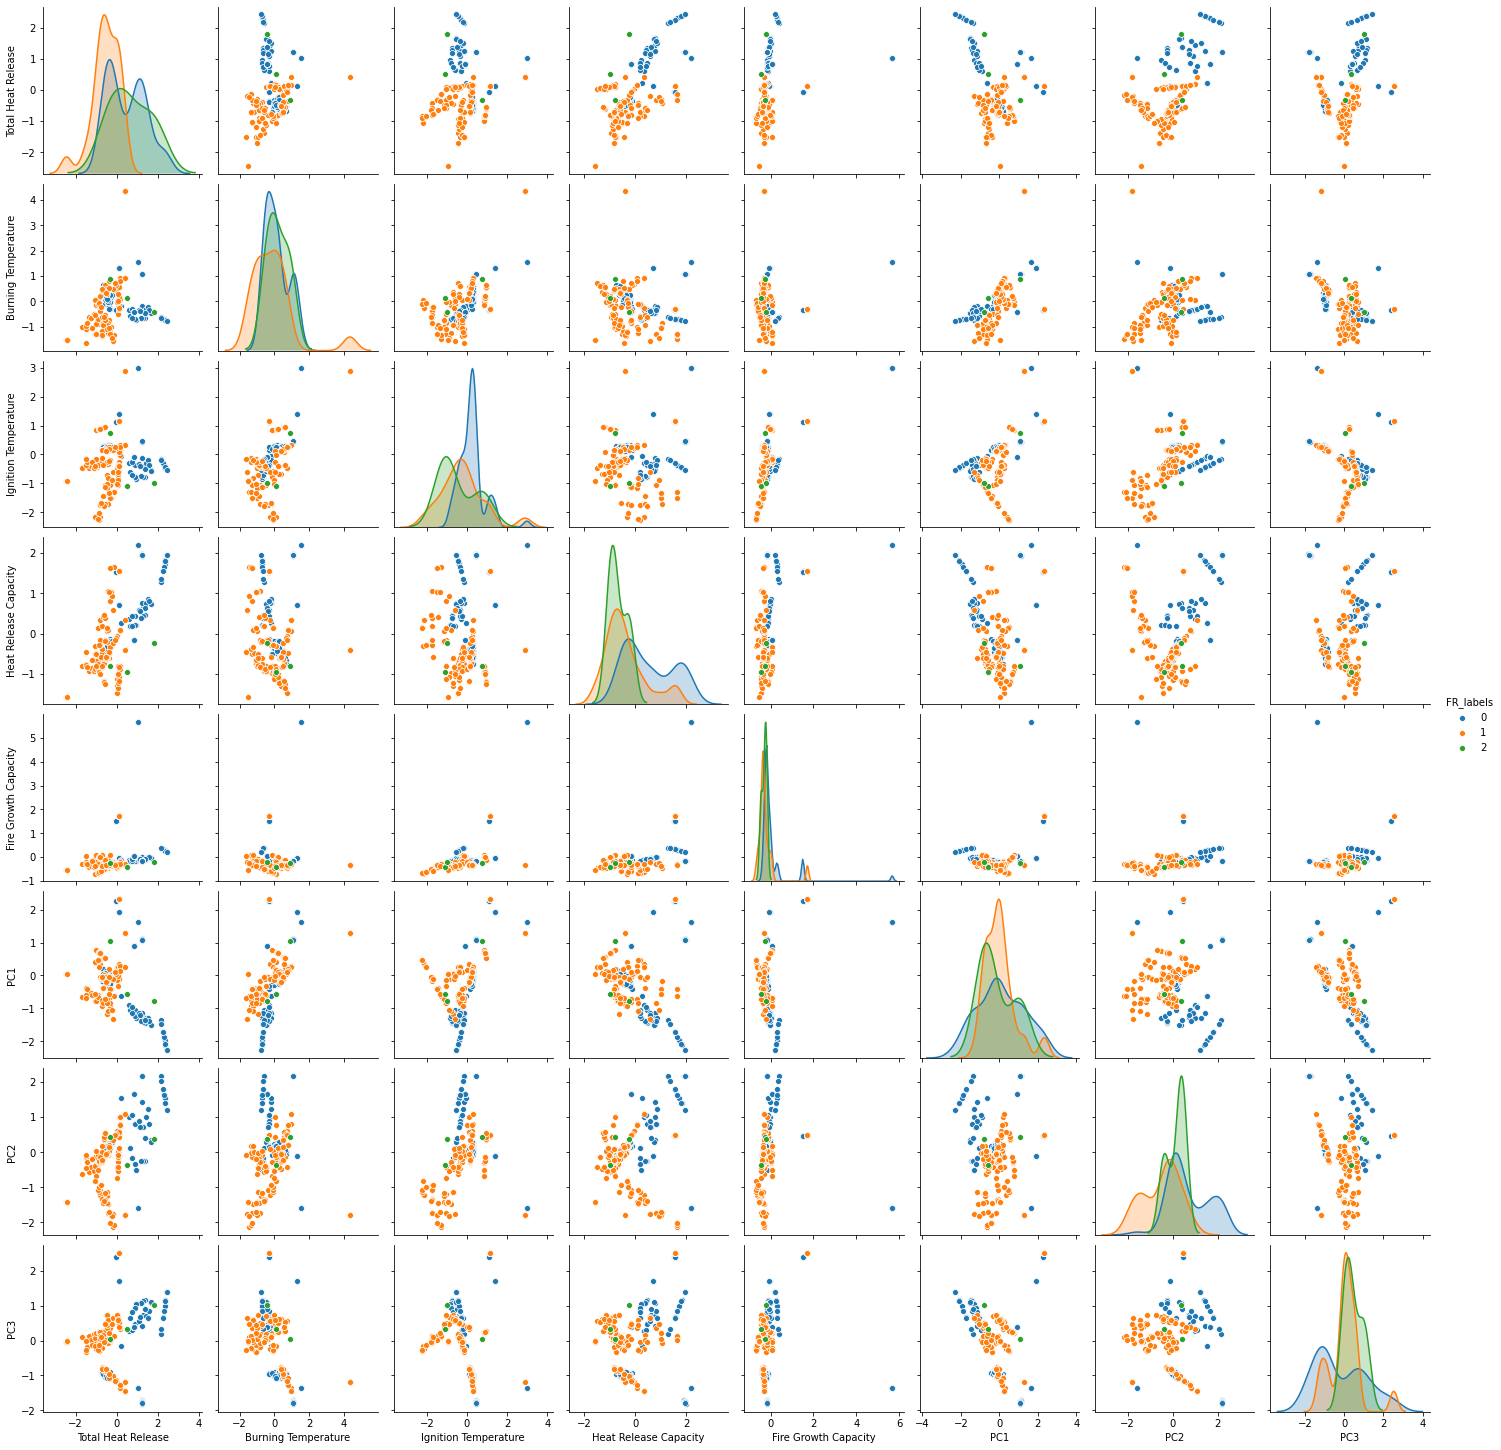

In [34]:
sns.pairplot(final,hue='FR_labels')

### Kernel Density Estimation

In [35]:
from sklearn.neighbors import KernelDensity

vals = []
for i in range(0,2):
  X = train.drop(columns='FR_labels')[y == i].values

  # use the best estimator to compute the kernel density estimate
  kde = KernelDensity(kernel='gaussian', bandwidth=.5)
  kde.fit(X)

  new = kde.sample(100)
  vals.append(new)

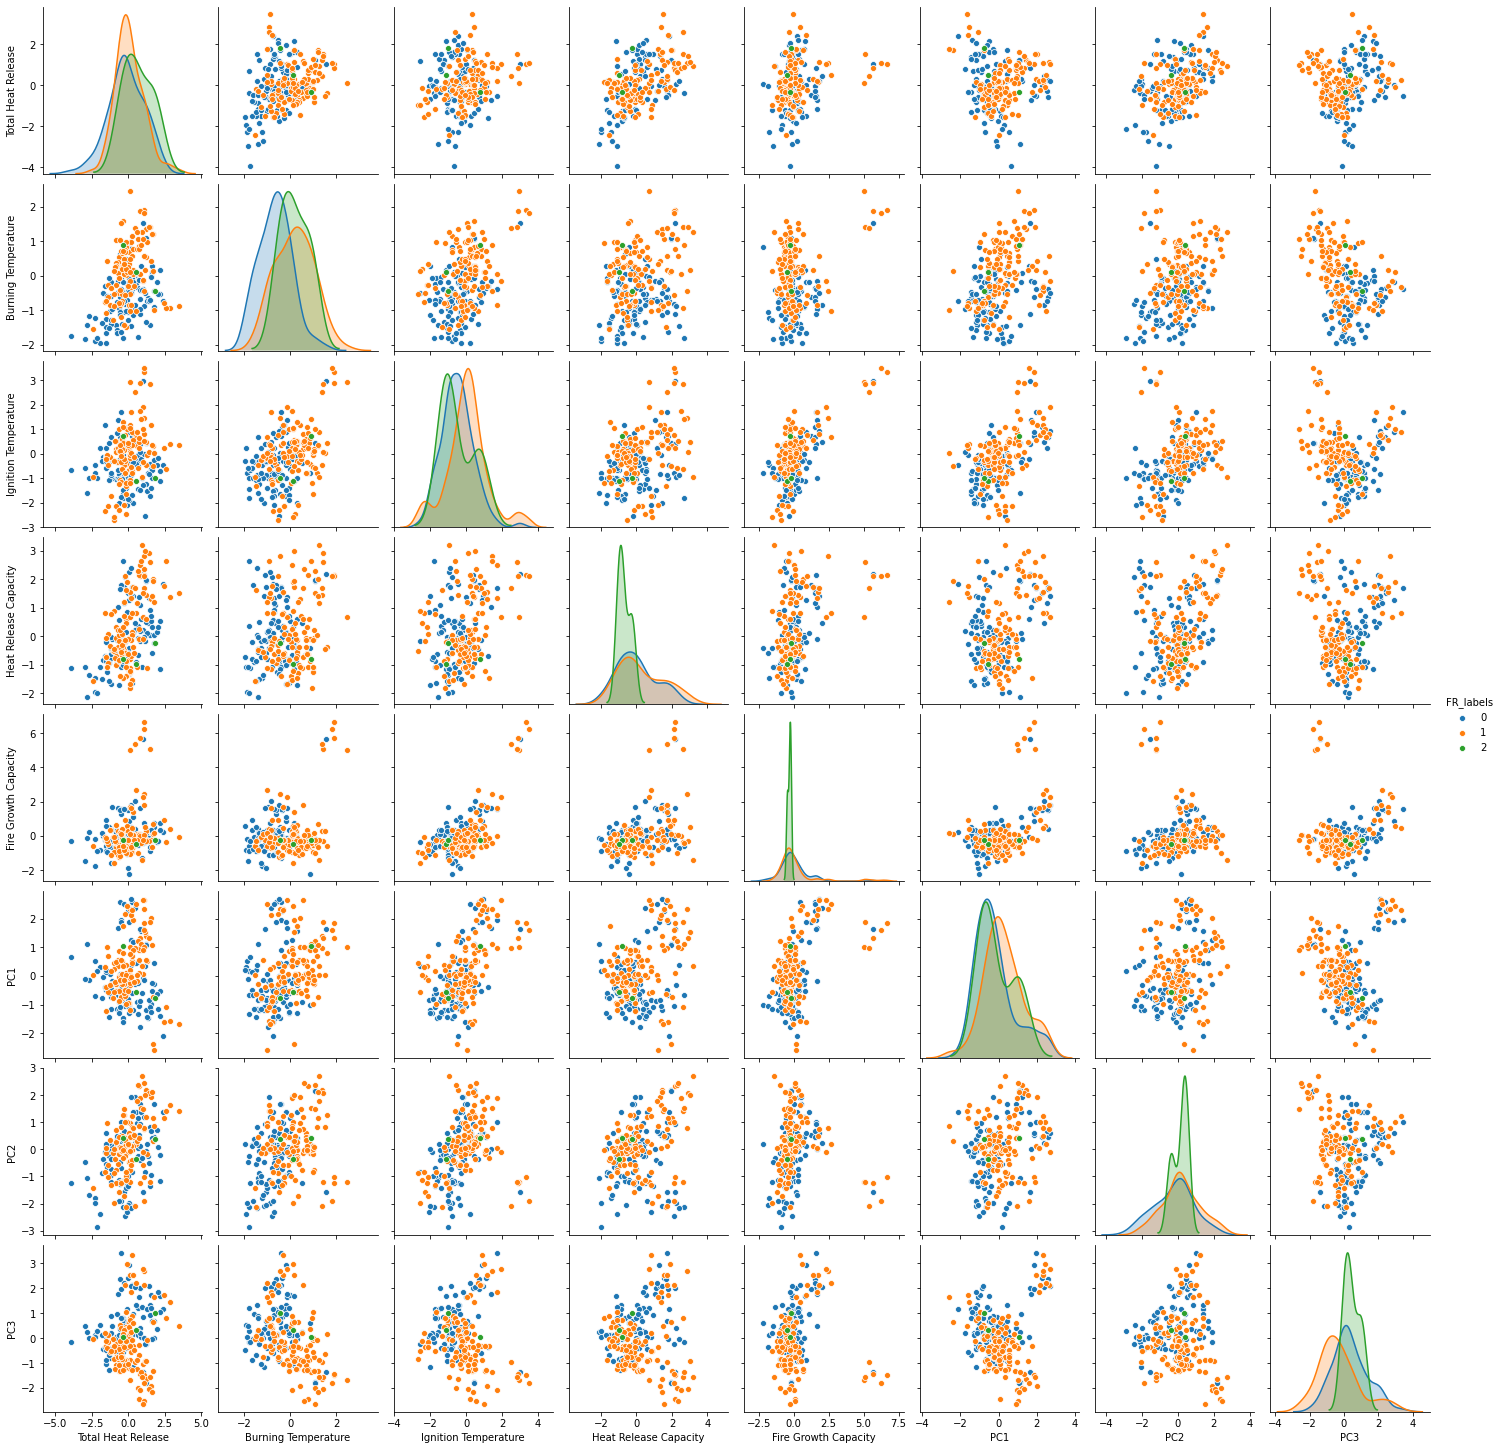

In [36]:
new0 = pd.DataFrame(vals[0])
new0['FR_labels'] = np.zeros(100).astype(int)
new0.columns = scaled.columns
new1 = pd.DataFrame(vals[1])
new1['FR_labels'] = np.ones(100).astype(int)
new1.columns = scaled.columns
kde_plot = train.append(new0)
kde_plot = kde_plot.append(new1)
sns.pairplot(kde_plot,hue='FR_labels')

## 3.2 Classifiers

In [37]:
#X_ori=origin_feature_matrix.drop(columns='FR_labels').values
#y_ori=origin_feature_matrix['FR_labels'].values
X_ori = X_test
y_ori = y_test
X_ori.shape

(11, 8)

### SVC (Baseline model)

In [38]:
# perform a train-test split. 90% of original data will be used for training
X_svc = final.drop(columns='FR_labels').values
print(X_svc.shape)
y_svc = final['FR_labels'].values
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_svc, test_size = 0.25)

# define support vector model with rbf kernel
svc = SVC(kernel = 'rbf')

# build up parameter grid and perform GridSearchCV to find the best estimator
alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
Cs = 1 / alphas
sigmas = np.array([1e-3, 1e-2, 1e-1, 1, 10, 100])
gammas = 1. / 2 / sigmas**2

param_grid_svc = {'C': Cs,'gamma': gammas}

svc_search = GridSearchCV(svc, param_grid_svc, cv = 5)
svc_search.fit(X_train_svc,y_train_svc)

# Get best estimator and use hyperparameters to fit best_svc model

print(svc_search.best_estimator_)

best_svc = SVC(kernel = 'rbf',C=100,gamma=0.5)
%time best_svc.fit(X_train_svc,y_train_svc)


# resulting predictions
predict_svc = svc_search.best_estimator_.predict(X_test_svc)
full_predict_svc = svc_search.best_estimator_.predict(X_svc)
origin_predict_svc = svc_search.best_estimator_.predict(X_ori)
# note: we have 3 labels, so we use average='macro' to find the average metric for each
#       label summed. This augments penalized performance caused by class imbalance.
# print out the accuracy, precison and recall score for the prediction on validation set
print('Accuracy for validation set: {}'.format(accuracy_score(y_test_svc, predict_svc)))
print('Precision for validation set: {}'.format(precision_score(y_test_svc, predict_svc, average='macro')))
print('Recall for validation set: {}\n'.format(recall_score(y_test_svc, predict_svc, average='macro')))

# print out the accuracy, precison and recall score for the prediction on full dataset
print('Accuracy for full dataset: {}'.format(accuracy_score(y_svc, full_predict_svc)))
print('Precision for full dataset: {}'.format(precision_score(y_svc, full_predict_svc, average='macro')))
print('Recall for full dataset: {}\n'.format(recall_score(y_svc, full_predict_svc, average='macro')))

# print out the accuracy, precison and recall score for the prediction on original dataset (before data generation)
print('Accuracy for original dataset: {}'.format(accuracy_score(y_ori, origin_predict_svc)))
print('Precision for original dataset: {}'.format(precision_score(y_ori, origin_predict_svc, average='macro')))
print('Recall for original dataset: {}'.format(recall_score(y_ori, origin_predict_svc, average='macro')))

(230, 8)
SVC(C=1000000.0, gamma=0.5)
CPU times: user 1.31 ms, sys: 159 µs, total: 1.47 ms
Wall time: 1.22 ms
Accuracy for validation set: 0.896551724137931
Precision for validation set: 0.9142857142857144
Recall for validation set: 0.896551724137931

Accuracy for full dataset: 0.9739130434782609
Precision for full dataset: 0.9834710743801653
Recall for full dataset: 0.9821428571428571

Accuracy for original dataset: 0.9090909090909091
Precision for original dataset: 0.9166666666666667
Recall for original dataset: 0.9166666666666667


### Decision Tree

In [39]:
from sklearn.tree import DecisionTreeClassifier

X_DT = final.drop(columns='FR_labels').values
y_DT = final['FR_labels'].values
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_DT, y_DT, test_size = 0.25)

# Create dtree instance
dtree = DecisionTreeClassifier()

# Create parameter grid - currently just max depth
max_depths = [2,3,5,10,15,20, 100]
criterions = ['gini', 'entropy']
param_grid_dtree = {'max_depth': max_depths, 'criterion': criterions}
print(X_DT.shape)
print(y_DT.shape)


(230, 8)
(230,)


In [40]:
# GridSearch Hyperparameter Tuning
DT_search = GridSearchCV(dtree, param_grid_dtree, cv=5)
DT_search.fit(X_train_DT, y_train_DT)

print(DT_search.best_estimator_)

best_DT = DecisionTreeClassifier(max_depth=10)

%time best_DT.fit(X_train_DT, y_train_DT)

# Predict both the testing set and the full data set
dtree_prediction = DT_search.best_estimator_.predict(X_test_DT)
dtree_full_prediction = DT_search.best_estimator_.predict(X_DT)
dtree_origin_prediction = DT_search.best_estimator_.predict(X_ori)


# note: we have 3 labels, so we use average='macro' to find the average metric for each
#       label summed. This augments penalized performance caused by class imbalance.
# print out the accuracy, precison and recall score for the prediction on validation set
print('Accuracy for validation set: {}'.format(accuracy_score(y_test_DT, dtree_prediction)))
print('Precision for validation set: {}'.format(precision_score(y_test_DT, dtree_prediction, average='macro')))
print('Recall for validation set: {}\n'.format(recall_score(y_test_DT, dtree_prediction, average='macro')))

# print out the accuracy, precison and recall score for the prediction on full dataset
print('Accuracy for full dataset: {}'.format(accuracy_score(y_DT, dtree_full_prediction)))
print('Precision for full dataset: {}'.format(precision_score(y_DT, dtree_full_prediction, average='macro')))
print('Recall for full dataset: {}\n'.format(recall_score(y_DT, dtree_full_prediction, average='macro')))

# print out the accuracy, precison and recall score for the prediction on original dataset (before data generation)
print('Accuracy for original dataset: {}'.format(accuracy_score(y_ori, dtree_origin_prediction)))
print('Precision for original dataset: {}'.format(precision_score(y_ori, dtree_origin_prediction, average='macro')))
print('Recall for original dataset: {}'.format(recall_score(y_ori, dtree_origin_prediction, average='macro')))



DecisionTreeClassifier(max_depth=10)
CPU times: user 1.34 ms, sys: 276 µs, total: 1.62 ms
Wall time: 1.41 ms
Accuracy for validation set: 0.8793103448275862
Precision for validation set: 0.5880952380952381
Recall for validation set: 0.60125

Accuracy for full dataset: 0.9695652173913043
Precision for full dataset: 0.9802469135802468
Recall for full dataset: 0.8711093857832988

Accuracy for original dataset: 0.8181818181818182
Precision for original dataset: 0.8166666666666667
Recall for original dataset: 0.8166666666666667


### Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier


X_RF = final.drop(columns='FR_labels').values
y_RF = final['FR_labels'].values
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_RF, y_RF, test_size = 0.25)

# Instantiate random forest model
ranfor = RandomForestClassifier()

# Create parameter grid 
# We are searching over two hyperparameters for our Random Forest model

n_estimators = [3, 5, 7, 10, 15, 20, 25, 50, 100]
maximum_feats = ['auto', 'log2']
max_depths = [2,3,5,10,15,20, 100]
criterions = ['gini', 'entropy']
param_grid_ranfor = {'n_estimators': n_estimators, 'criterion': criterions, 'max_features': maximum_feats,'max_depth': max_depths}

In [42]:
# GridSearch Hyperparameter Tuning
RF_search = GridSearchCV(ranfor, param_grid_ranfor, cv=5)
RF_search.fit(X_train_RF, y_train_RF)

print(RF_search.best_estimator_)

best_RF = RandomForestClassifier(max_depth=20,n_estimators=10)

%time best_RF.fit(X_train_DT, y_train_DT)
best_RF.predict(X_ori)


# Predict both the testing set and the full data set
ranfor_prediction = RF_search.best_estimator_.predict(X_test_RF)
ranfor_full_prediction = RF_search.best_estimator_.predict(X_RF)
ranfor_origin_prediction = RF_search.best_estimator_.predict(X_ori)

# note: we have 3 labels, so we use average='macro' to find the average metric for each
#       label summed. This augments penalized performance caused by class imbalance.
# print out the accuracy, precison and recall score for the prediction on validation set
print('Accuracy for validation set: {}'.format(accuracy_score(y_test_RF, ranfor_prediction)))
print('Precision for validation set: {}'.format(precision_score(y_test_RF, ranfor_prediction, average='macro')))
print('Recall for validation set: {}\n'.format(recall_score(y_test_RF, ranfor_prediction, average='macro')))

# print out the accuracy, precison and recall score for the prediction on full dataset
print('Accuracy for full dataset: {}'.format(accuracy_score(y_RF, ranfor_full_prediction)))
print('Precision for full dataset: {}'.format(precision_score(y_RF, ranfor_full_prediction, average='macro')))
print('Recall for full dataset: {}\n'.format(recall_score(y_RF, ranfor_full_prediction, average='macro')))

# print out the accuracy, precison and recall score for the prediction on original dataset (before data generation)
print('Accuracy for original dataset: {}'.format(accuracy_score(y_ori, ranfor_origin_prediction)))
print('Precision for original dataset: {}'.format(precision_score(y_ori, ranfor_origin_prediction, average='macro')))
print('Recall for original dataset: {}'.format(recall_score(y_ori, ranfor_origin_prediction, average='macro')))

# I have noticed that the accuracy for the validation set changes pretty wildly each time I re-run the previous block with the test_train_split

RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=5)
CPU times: user 12.2 ms, sys: 524 µs, total: 12.8 ms
Wall time: 12.9 ms
Accuracy for validation set: 0.9827586206896551
Precision for validation set: 0.9838709677419355
Recall for validation set: 0.9821428571428572

Accuracy for full dataset: 0.991304347826087
Precision for full dataset: 0.9941520467836257
Recall for full dataset: 0.8859903381642512

Accuracy for original dataset: 1.0
Precision for original dataset: 1.0
Recall for original dataset: 1.0


### KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier

X_KNN = final.drop(columns='FR_labels').values
y_KNN = final['FR_labels'].values
X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X_KNN, y_KNN, test_size = 0.25)

KNN = KNeighborsClassifier()
# neighbors = np.array([2,4,6,8,10,12,15,18,20,15])
neighbors = np.array([2,3])
KNN_param_grid = {'n_neighbors': neighbors}

In [44]:
# Hyperparameter tunning
KNN_search = GridSearchCV(KNN, KNN_param_grid, cv=5)
#KNN_search.fit(X_train_KNN, y_train_KNN)
KNN_search.fit(X_train_KNN, y_train_KNN)

print(KNN_search.best_estimator_)

best_KNN = KNeighborsClassifier(n_neighbors=2)

%time best_KNN.fit(X_train_DT, y_train_DT)

# resulting predictions
predict_KNN = KNN_search.best_estimator_.predict(X_test_KNN)
full_predict_KNN = KNN_search.best_estimator_.predict(X_KNN)
origin_predict_KNN = KNN_search.best_estimator_.predict(X_ori)

# note: we have 3 labels, so we use average='macro' to find the average metric for each
#       label summed. This augments penalized performance caused by class imbalance.
# print out the accuracy, precison and recall score for the prediction on validation set
print('Accuracy for validation set: {}'.format(accuracy_score(y_test_KNN, predict_KNN)))
print('Precision for validation set: {}'.format(precision_score(y_test_KNN, predict_KNN, average='macro')))
print('Recall for validation set: {}\n'.format(recall_score(y_test_KNN, predict_KNN, average='macro')))

# print out the accuracy, precison and recall score for the prediction on full dataset
print('Accuracy for full dataset: {}'.format(accuracy_score(y_KNN, full_predict_KNN)))
print('Precision for full dataset: {}'.format(precision_score(y_KNN, full_predict_KNN, average='macro')))
print('Recall for full dataset: {}\n'.format(recall_score(y_KNN, full_predict_KNN, average='macro')))

# print out the accuracy, precison and recall score for the prediction on original dataset (before data generation)
print('Accuracy for original dataset: {}'.format(accuracy_score(y_ori, origin_predict_KNN)))
print('Precision for original dataset: {}'.format(precision_score(y_ori, origin_predict_KNN, average='macro')))
print('Recall for original dataset: {}'.format(recall_score(y_ori, origin_predict_KNN, average='macro')))

KNeighborsClassifier(n_neighbors=2)
CPU times: user 1.02 ms, sys: 196 µs, total: 1.22 ms
Wall time: 1.19 ms
Accuracy for validation set: 1.0
Precision for validation set: 1.0
Recall for validation set: 1.0

Accuracy for full dataset: 0.9695652173913043
Precision for full dataset: 0.6465219474069032
Recall for full dataset: 0.6550724637681159

Accuracy for original dataset: 1.0
Precision for original dataset: 1.0
Recall for original dataset: 1.0


## 3.3 Model Comparison

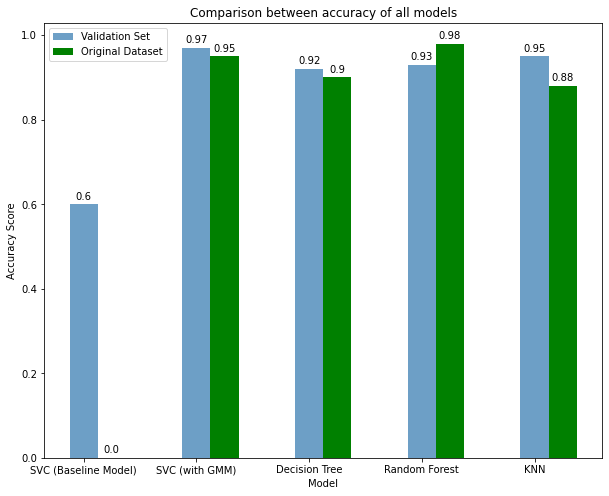

In [47]:
from matplotlib.pyplot import figure
labels = ['SVC (Baseline Model)', 'SVC (with GMM)', 'Decision Tree', 'Random Forest', 'KNN']
physical = (0.60, 0.97, 0.92, 0.93, 0.95)
pca = (0, 0.95, 0.90, 0.98, 0.88)
n_groups = 5
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
index = np.arange(n_groups)
bar_width = 0.25

fig, ax = plt.subplots(figsize=(10,8))

rects1 = plt.bar(index, physical, bar_width,
alpha=0.8,
color='#4887b8',
label='Validation Set')

rects2 = plt.bar(index + bar_width, pca, bar_width,
alpha=1,
color='g',
label='Original Dataset')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Model')
ax.set_title('Comparison between accuracy of all models')
ax.set_xticks(x)
ax.set_xticklabels(labels)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.legend()

plt.show()

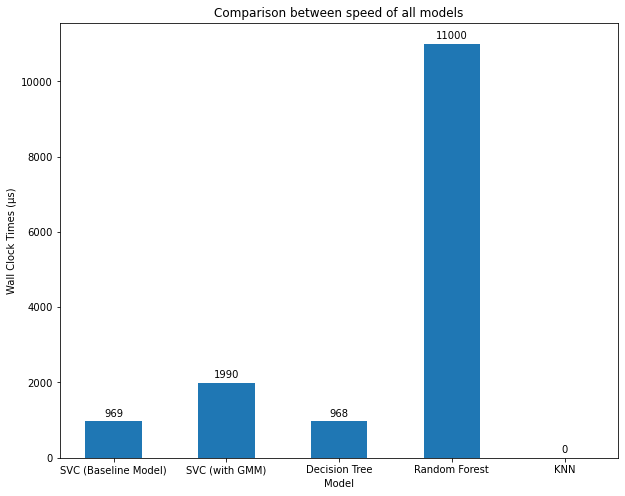

In [48]:
labels = ['SVC (Baseline Model)', 'SVC (with GMM)', 'Decision Tree', 'Random Forest', 'KNN']
physical = (969, 1990, 968, 11000, 0)

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x, physical, width, label='Men')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Wall Clock Times (\N{greek small letter mu}s)')
ax.set_xlabel('Model')
ax.set_title('Comparison between speed of all models')
ax.set_xticks(x)
ax.set_xticklabels(labels)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

plt.show()